In [26]:
import scipy.io as sio
import matlab.engine
import numpy as np
from scipy import stats

mat = matlab.engine.start_matlab()

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

In [5]:
def draw_bs_replicates(data,func,size):
    """creates a bootstrap sample, computes replicates and returns replicates array"""
    # Create an empty array to store replicates
    bs_replicates = np.empty(size)
    
    # Create bootstrap replicates as much as size
    for i in range(size):
        # Create a bootstrap sample
        bs_sample = np.random.choice(data,size=len(data))
        # Get bootstrap replicate and append to bs_replicates
        bs_replicates[i] = func(bs_sample)
    
    return bs_replicates

In [147]:
exp_num = 1
paths = ['/mnt/cube/home/lkueida/Documents/MATLAB/MemoryFinale/LOSO/Exp1/',
         '/mnt/cube/home/lkueida/Documents/MATLAB/MemoryFinale/LOSO/Exp2/']
path = paths[exp_num]

exps = ['_1','_2']
exp = exps[exp_num]

user_lens = [26,28]
user_len = user_lens[exp_num]

CRSNMN = [('CRSN','CRMN'), ([12],[10]), 'CRSN_vs_CRMN','']
CRSNMN_ImC = [('CRSN','CRMN'), ([12],[10]), 'CRSN_vs_CRMN','_ImC']
clfs = [CRSNMN, CRSNMN_ImC]
clf_paths = ['CR_M_SN_MN/','linreg_RSF_SCRSvsSIRS_CRSNvsCRMN/','']
match_bias = ['','_matchSICR']

In [148]:
behav_label = [(1,1),(3,1),(5,1),(1,2),(3,2),(5,2),(1,3),(3,3),(5,3),(4,4),(2,4),(4,5),(2,5)]
behav_name = ['SC-RS','SI-RS','FA-RS','SC-RO','SI-RO','FA-RO','SC-F','SI-F','FA-F','M-MN','CR-MN','M-SN','CR-SN']

In [149]:
user_cnt_b = [0]*13
user_score_all = [[],[]]
statz = np.zeros((2,13,3))
for i, (clf, c_path, mbias) in enumerate(zip(clfs, clf_paths, match_bias)):
    filename = path + c_path + 'data_' + clf[2] + '_imbalLDA_order_proj' + mbias + exp +'.mat'
    matfile = mat.load(filename, nargout=1)

    for j in range(13):
        user_score = []
        for u in range(user_len):

            temp_score = matfile['user_prob'+exp][u]
            temp_source = matfile['user_source'+exp][u]
            temp_resp = matfile['user_resp'+exp][u]
            temp_score = np.array(temp_score._data).reshape(temp_score.size, order='F')
            temp_source = np.array(temp_source._data).reshape(temp_source.size, order='F')
            temp_resp = np.array(temp_resp._data).reshape(temp_resp.size, order='F')
            b = (temp_source==behav_label[j][0]) & (temp_resp==behav_label[j][1])
            if sum(b)[0] < 5:
                continue
            user_score.append(np.mean(temp_score[b]))
            
            
        sample = draw_bs_replicates(user_score, np.mean, 10000)
        statz[i,j,0] = np.mean(sample)
        statz[i,j,1:] = np.percentile(sample,[2.5,97.5])
        
        user_cnt_b[j] = len(user_score)
        user_score_all[i] += user_score

In [150]:
slope, intercept, r_value, p_value, std_err = stats.linregress(user_score_all[0], user_score_all[1])

In [151]:
np.mean(user_score_all[0]), np.median(user_score_all[0])

(0.01473259782362799, 0.02243419528731387)

In [152]:
np.mean(user_score_all[1]), np.median(user_score_all[1])

(0.03780448176817068, 0.03474425813636382)

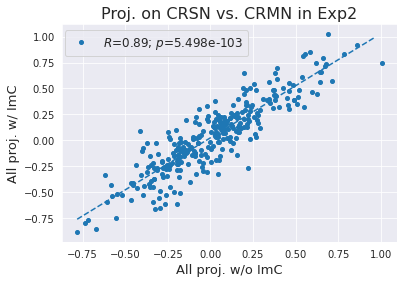

In [153]:
fig, ax1 = plt.subplots()

l1, = ax1.plot(user_score_all[0], user_score_all[1],'o', 
         markersize=4,
         label=r'$R$='+str(round(r_value, 2)) + r'; $p$=' + '{:.3e}'.format(p_value/2))

ax1.plot(np.arange(min(user_score_all[0]),max(user_score_all[0]),0.05), 
         intercept + slope*np.arange(min(user_score_all[0]),max(user_score_all[0]),0.05), '--', color='C0')

plt.title('Proj. on CRSN vs. CRMN in Exp'+str(exp_num+1), fontsize=16)
ax1.set_xlabel('All proj. w/o ImC', fontsize=13)
ax1.set_ylabel('All proj. w/ ImC', fontsize=13)
plt.legend(handles=[l1], loc=2, fontsize=12, bbox_to_anchor=(-.01, 1.0, 0., 0.))
plt.savefig('CRSN_vs_CRMN_wwo_ImC_proj_'+str(exp_num+1)+'.png', dpi=600)

In [128]:
statz[0,:,0]

array([ 0.20082471,  0.17341816, -0.00990479,  0.11611471,  0.04078436,
       -0.16751604, -0.08480536, -0.08479495, -0.19075326, -0.15479391,
       -0.06290789,  0.06727128,  0.13928801])

In [129]:
stats.ttest_rel(user_score_all[0]-np.mean(statz[0,:,0]), user_score_all[1]-np.mean(statz[1,:,0]))

Ttest_relResult(statistic=0.15319478920473592, pvalue=0.878349048276378)

In [111]:
stats.ttest_rel(user_score_all[0]-np.median(statz[0,:,0]), user_score_all[1]-np.median(statz[1,:,0]))

Ttest_relResult(statistic=-6.282612632835347, pvalue=1.268862583079485e-09)

In [120]:
stats.ttest_rel(user_score_all[0]-np.mean(statz[0,[10,12],0]), user_score_all[1]-np.mean(statz[1,[10,12],0]))

Ttest_relResult(statistic=-5.418652860047043, pvalue=1.2956378386681963e-07)

In [130]:
user_cnt_b

[28, 24, 9, 28, 28, 17, 24, 23, 19, 20, 26, 23, 28]

In [131]:
head = 0
t_res = np.zeros((13,2))
for i, b_cnt in enumerate(user_cnt_b):
    tail = head + b_cnt
    user_score_wo = user_score_all[0][head:tail]
    user_score_w = user_score_all[1][head:tail]
    t, p = stats.ttest_rel(user_score_wo-np.mean(statz[0,:,0]), user_score_w-np.mean(statz[1,:,0]))
#     t, p = stats.ttest_rel(user_score_wo-np.median(statz[0,:,0]), user_score_w-np.median(statz[1,:,0]))
    t_res[i,0] = t
    t_res[i,1] = p
    head = tail
    print(behav_name[i]+': t-stat=' + str(round(t,3)) + ', p-val=' + str(round(p,4)))

SC-RS: t-stat=-2.534, p-val=0.0174
SI-RS: t-stat=-0.926, p-val=0.3642
FA-RS: t-stat=-0.925, p-val=0.3822
SC-RO: t-stat=-1.179, p-val=0.2488
SI-RO: t-stat=-1.107, p-val=0.278
FA-RO: t-stat=0.015, p-val=0.988
SC-F: t-stat=1.139, p-val=0.2665
SI-F: t-stat=0.403, p-val=0.6905
FA-F: t-stat=0.21, p-val=0.8358
M-MN: t-stat=-0.094, p-val=0.9264
CR-MN: t-stat=2.283, p-val=0.0312
M-SN: t-stat=0.612, p-val=0.547
CR-SN: t-stat=1.079, p-val=0.2899


In [140]:
def plot_score(data, cType, m_bias):
    
    other_idx = np.ones((13,))
    for c in cType[1][0]:
        other_idx[c] = 0
    for c in cType[1][1]:
        other_idx[c] = 0
    
    errors = np.abs(np.transpose(data[:,1:] - data[:,:1]))
#     print(errors)
    others = np.arange(13)[other_idx.astype(bool)]
    plt.figure()
    plt.errorbar(others, data[others,0], yerr=errors[:,others], fmt='o', capsize=3, c = 'black')
    pos = plt.errorbar(cType[1][0],data[cType[1][0],0], yerr=errors[:,cType[1][0]], fmt='o', capsize=3, c = 'limegreen')
    neg = plt.errorbar(cType[1][1],data[cType[1][1],0], yerr=errors[:,cType[1][1]], fmt='o', capsize=3, c = 'red')

    ax = plt.gca()
    ax.set_xticks(np.arange(13))
    ax.set_xticklabels(behav_name, fontsize=14)

    if exp_num==0:
        pos.set_label(cType[0][0])
        neg.set_label(cType[0][1])
#         legend = ax.legend(title=r'$\bf{Trained\ Classes}$', fontsize=14, frameon=False)
        legend = ax.legend(title=r'$\bf{Trained\ Classes}$', fontsize=14,loc='best',
                           bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), frameon=False)
        legend.get_title().set_fontsize('12')

    plt.xticks(rotation=45)
    plt.yticks(fontsize=14)
    plt.ylabel('Classifier projection', fontsize=14);
#     plt.title('Projections onto ' + cType[0][0] + ' vs. ' + cType[0][1] + ' classifier in Exp' + exp)
    plt.tight_layout()
    
    filename = cType[0][0] + '_vs_' + cType[0][1] + cType[3] + '_subscores_Exp' + str(exp_num+1) 
    plt.savefig(filename+'.pdf')

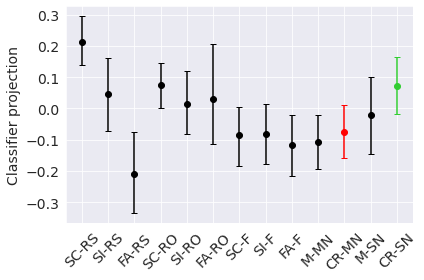

In [141]:
plot_score(statz[0,:,:], clfs[0], match_bias[0])

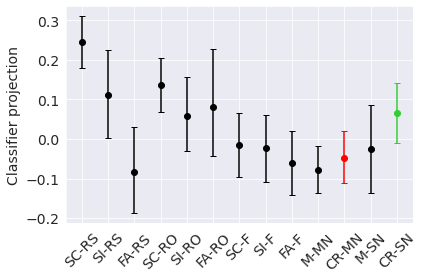

In [142]:
plot_score(statz[1,:,:], clfs[1], match_bias[1])